In [17]:
from typing import List

from oop_functions.experiment_helper import *
from oop_functions.experiment_runner import ExperimentRunner
from oop_functions.util_functions import summarize_features, print_df
from oop_functions.visualization_util import *
from oop_functions.analytics_cv_util import *

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from xgboost import XGBClassifier

import itertools


In [18]:
processed_data = pd.read_csv('./processed_dataset/recent_propagated_dataset.csv', index_col=0)
missing_df = pd.read_csv('./missing_features/combined_missing.csv', index_col=0)

In [19]:
# TODO: convert to float16

## Merging Datasets

I realized that I was doing labeled mean imputation, which should not happen. So, I performed imputation after I merged cancer and no_cancer datasets back together. Without labeled mean imputation, gaussian NB and logistic regression do not perform well. 

run experiments with decision tree and remove the top feature every time. Store the depth of the tree, the efficacy of the top feature, its value, accuracy, confusion matrix

https://stackoverflow.com/questions/62819569/how-to-return-the-features-that-used-in-decision-tree-that-created-by-decisiontr

`TODO:` divide them as FP and FN?

`TODO:` only keep columns with more than 1 unique value? 

`TODO:` make spreadsheet with model performance for 1,3,5,10 years. Print out trees, top 5 features. Send models

`TODO:` try SVM or ML models

`TODO:` At what point they were misclassified (e.g. at what point they diverge compared to the similar point with different prediction.) Look at the nearest neightbors with different neightbors. 

In [20]:
def isin_filter(df: pd.DataFrame, col: str, values: List):
    return df[df[col].isin(values)]

# filtered_on = list(itertools.chain.from_iterable([zip([key]*len(vals), vals) for key, vals in differentiate_confusion_matrix_over.items()]))
# TODO: finish this one
differentiate_confusion_matrix_over = {
    'was_screened': [
        ([0], lambda df: isin_filter(df, 'was_screened', [0])), 
        ([1], lambda df: isin_filter(df, 'was_screened', [1]))
    ], 
    'ovar_histtype': [
        ([2], lambda df: isin_filter(df, 'ovar_histtype', [2])), 
        ([2, 4, 6, 8, 9, 31], lambda df: isin_filter(df, 'ovar_histtype', [2, 4, 6, 8, 9, 31]))
    ]
}


In [21]:
cv_analytics_utils = {}

In [22]:
classifiers = {
    # 'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy'),
    # 'RandomForestClassifier': RandomForestClassifier(criterion= 'entropy', n_estimators= 200),
    'XGBClassifier': XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
}

experiment_data_helpers: List[ExperimentDataHelper] = [
    ExperimentDataHelperScreenedOrCancer,
    ExperimentDataHelperScreened,
    ExperimentDataHelperNotScreenedCols,
    ExperimentDataHelperScreenedCols,
    ExperimentDataHelperAll,
    ExperimentDataHelperSingleLabelScreenedOrCancer,
    ExperimentDataHelperSingleLabelScreened,
    ExperimentDataHelperSingleLabelNotScreenedCols,
    ExperimentDataHelperSingleLabelScreenedCols,
    ExperimentDataHelperSingleLabelAll
]

In [23]:
years = [1, 5]
num_folds=10
test_n_folds=10
train_size = 15000
for classifier_name, classifier in classifiers.items():
    for year in years:
        for experiment_data_helper_class in experiment_data_helpers:
            label = f'cancer_in_next_{year}_years'
            filesuffix = f'experiment_{experiment_data_helper_class.get_name()}_{classifier_name}_for_{label}_{num_folds}_trials'
            print(filesuffix)
            experiment_data_helper: ExperimentDataHelper = experiment_data_helper_class(processed_data, label, ['cancer_'], train_size = train_size)
            # experiment_data_helper.set_train_size_to_max(num_folds)
            experiment_runner = ExperimentRunner(classifier, experiment_data_helper, missing_df, num_folds=num_folds, test_n_folds=test_n_folds)
            cv_analytics_util = experiment_runner.run_experiment()
            cv_analytics_utils[filesuffix] = cv_analytics_util
            cv_analytics_util.store_cv_analytics_utils(filesuffix)


experiment_participants_screened_or_cancer_XGBClassifier_for_cancer_in_next_1_years_10_trials
experiment_participants_screened_XGBClassifier_for_cancer_in_next_1_years_10_trials
experiment_not_screened_cols_XGBClassifier_for_cancer_in_next_1_years_10_trials
experiment_screened_cols_XGBClassifier_for_cancer_in_next_1_years_10_trials
experiment_participants_all_XGBClassifier_for_cancer_in_next_1_years_10_trials
experiment_participants_screened_or_cancer_single_label_XGBClassifier_for_cancer_in_next_1_years_10_trials
experiment_participants_screened_single_label_XGBClassifier_for_cancer_in_next_1_years_10_trials
experiment_not_screened_cols_single_label_XGBClassifier_for_cancer_in_next_1_years_10_trials
experiment_screened_cols_single_label_XGBClassifier_for_cancer_in_next_1_years_10_trials
experiment_participants_all_single_label_XGBClassifier_for_cancer_in_next_1_years_10_trials
experiment_participants_screened_or_cancer_XGBClassifier_for_cancer_in_next_5_years_10_trials
experiment_part

In [24]:
# cv_analytics_util.set_filter(differentiate_confusion_matrix_over['was_screened'][0][1])

experiment_participants_screened_or_cancer_XGBClassifier_for_cancer_in_next_1_years_10_trials: 


Cross-Validation measures:
+--------------------+-----------+-------------+-----------+-----------+
|                    |      mean |         std |       min |       max |
|--------------------+-----------+-------------+-----------+-----------|
| precision__class_0 | 0.998813  | 4.88042e-05 | 0.998728  | 0.998882  |
| recall__class_0    | 0.980577  | 0.00212823  | 0.977419  | 0.983074  |
| f1-score__class_0  | 0.98961   | 0.00108978  | 0.987993  | 0.990915  |
| precision__class_1 | 0.0564675 | 0.00663527  | 0.048     | 0.0669456 |
| recall__class_1    | 0.496721  | 0.0205191   | 0.459016  | 0.52459   |
| f1-score__class_1  | 0.101318  | 0.010918    | 0.0874636 | 0.118738  |
| accuracy           | 0.979459  | 0.00213271  | 0.976298  | 0.982015  |
| auc                | 0.898643  | 0.00725464  | 0.885745  | 0.909744  |
+--------------------+-----------+-------------+-----------+-----------+

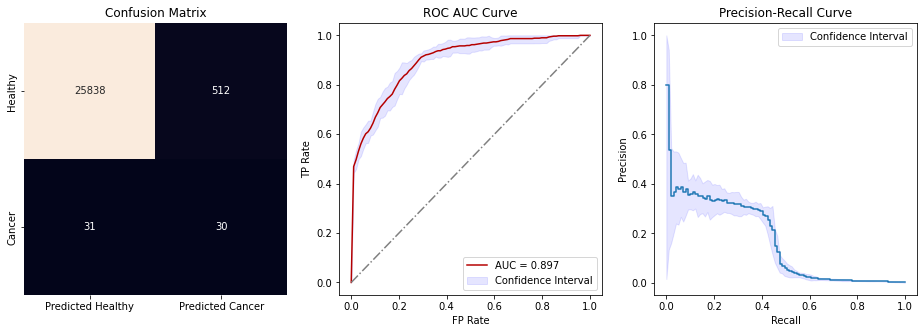

experiment_participants_screened_XGBClassifier_for_cancer_in_next_1_years_10_trials: 


Cross-Validation measures:
+--------------------+------------+-------------+------------+-----------+
|                    |       mean |         std |        min |       max |
|--------------------+------------+-------------+------------+-----------|
| precision__class_0 | 0.998934   | 5.85002e-05 | 0.998822   | 0.999048  |
| recall__class_0    | 0.963829   | 0.00350315  | 0.957701   | 0.969324  |
| f1-score__class_0  | 0.981064   | 0.00179298  | 0.977899   | 0.983852  |
| precision__class_1 | 0.00830656 | 0.00108203  | 0.00617284 | 0.0102612 |
| recall__class_1    | 0.228571   | 0.0446706   | 0.142857   | 0.314286  |
| f1-score__class_1  | 0.0160262  | 0.00211692  | 0.0118343  | 0.0198735 |
| accuracy           | 0.96285    | 0.00344948  | 0.956768   | 0.968223  |
| auc                | 0.827059   | 0.0107976   | 0.814028   | 0.843844  |
+--------------------+------------+-------------+-----------

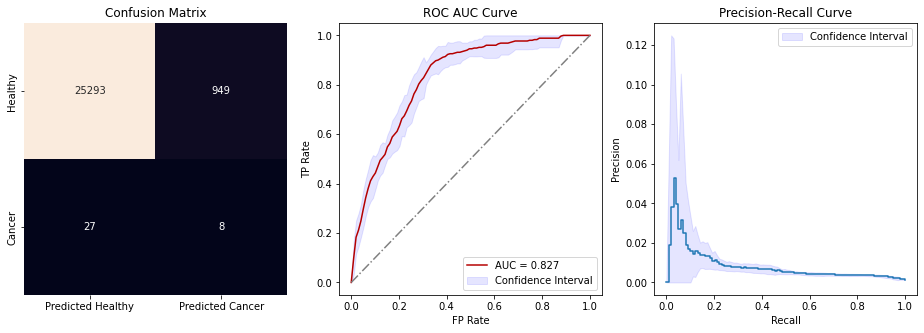

experiment_not_screened_cols_XGBClassifier_for_cancer_in_next_1_years_10_trials: 


Cross-Validation measures:
+--------------------+------------+-------------+------------+------------+
|                    |       mean |         std |        min |        max |
|--------------------+------------+-------------+------------+------------|
| precision__class_0 | 0.999326   | 6.09354e-05 | 0.99921    | 0.999412   |
| recall__class_0    | 0.881849   | 0.00532279  | 0.873624   | 0.889756   |
| f1-score__class_0  | 0.936912   | 0.00302113  | 0.932207   | 0.941402   |
| precision__class_1 | 0.00576099 | 0.000624312 | 0.00461437 | 0.00678605 |
| recall__class_1    | 0.534426   | 0.040304    | 0.459016   | 0.590164   |
| f1-score__class_1  | 0.0113989  | 0.00123074  | 0.00913689 | 0.0134178  |
| accuracy           | 0.881406   | 0.00534817  | 0.873096   | 0.889374   |
| auc                | 0.834065   | 0.00928092  | 0.818841   | 0.852456   |
+--------------------+------------+-------------+----

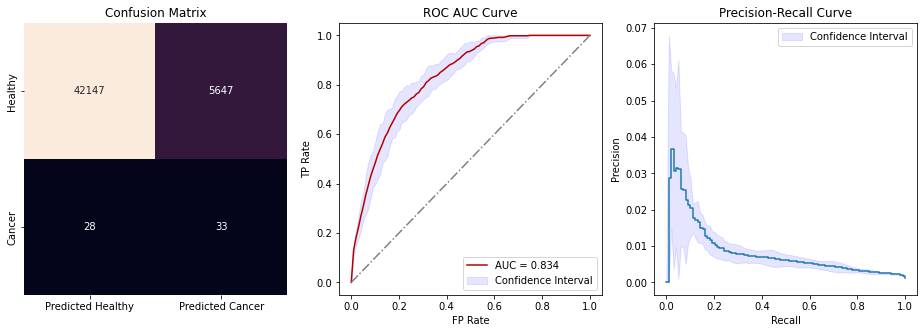

experiment_screened_cols_XGBClassifier_for_cancer_in_next_1_years_10_trials: 


Cross-Validation measures:
+--------------------+------------+-------------+------------+-----------+
|                    |       mean |         std |        min |       max |
|--------------------+------------+-------------+------------+-----------|
| precision__class_0 | 0.998737   | 4.45471e-05 | 0.998678   | 0.998813  |
| recall__class_0    | 0.934071   | 0.0275275   | 0.892196   | 0.95652   |
| f1-score__class_0  | 0.965132   | 0.0148668   | 0.942457   | 0.977187  |
| precision__class_1 | 0.00239976 | 0.000760292 | 0.00152207 | 0.0036075 |
| recall__class_1    | 0.114286   | 0.0446706   | 0.0571429  | 0.2       |
| f1-score__class_1  | 0.00468923 | 0.001473    | 0.00296516 | 0.0070373 |
| accuracy           | 0.932979   | 0.0274475   | 0.891198   | 0.955398  |
| auc                | 0.557053   | 0.0111396   | 0.531482   | 0.573371  |
+--------------------+------------+-------------+------------+------

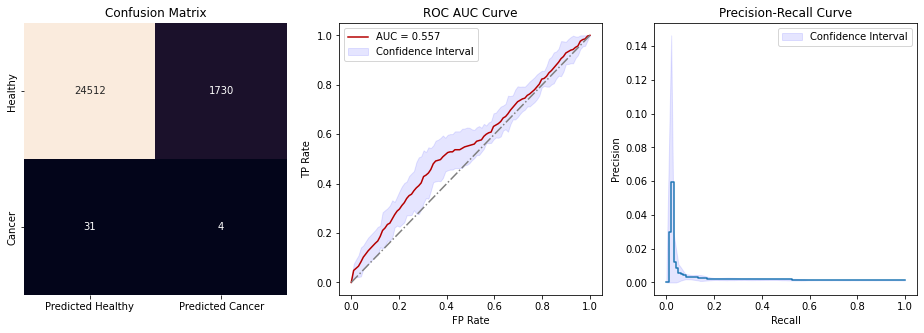

experiment_participants_all_XGBClassifier_for_cancer_in_next_1_years_10_trials: 


Cross-Validation measures:
+--------------------+------------+-------------+------------+------------+
|                    |       mean |         std |        min |        max |
|--------------------+------------+-------------+------------+------------|
| precision__class_0 | 0.999339   | 8.80918e-05 | 0.999188   | 0.9995     |
| recall__class_0    | 0.879353   | 0.00256717  | 0.875298   | 0.884128   |
| f1-score__class_0  | 0.935513   | 0.00146347  | 0.933149   | 0.93822    |
| precision__class_1 | 0.00572973 | 0.000660013 | 0.00450977 | 0.00681663 |
| recall__class_1    | 0.544262   | 0.0602581   | 0.442623   | 0.655738   |
| f1-score__class_1  | 0.01134    | 0.00130555  | 0.00892857 | 0.013493   |
| accuracy           | 0.878926   | 0.00258505  | 0.874747   | 0.883711   |
| auc                | 0.831951   | 0.00939907  | 0.81881    | 0.846766   |
+--------------------+------------+-------------+-----

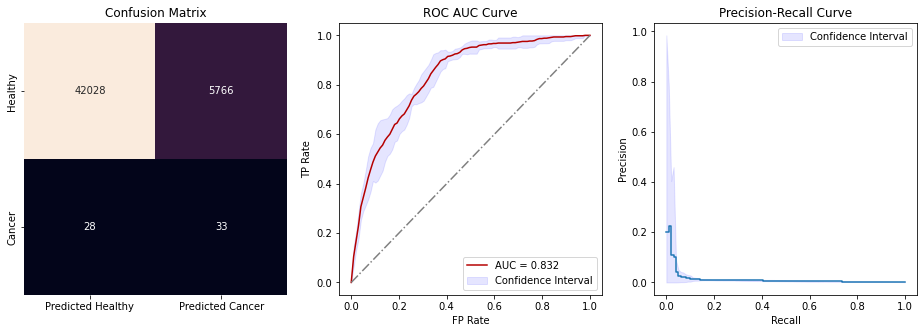

experiment_participants_screened_or_cancer_single_label_XGBClassifier_for_cancer_in_next_1_years_10_trials: 


Cross-Validation measures:
+--------------------+-----------+-------------+-----------+-----------+
|                    |      mean |         std |       min |       max |
|--------------------+-----------+-------------+-----------+-----------|
| precision__class_0 | 0.998827  | 4.29371e-05 | 0.99879   | 0.998907  |
| recall__class_0    | 0.981457  | 0.00173868  | 0.979635  | 0.985262  |
| f1-score__class_0  | 0.990065  | 0.000885556 | 0.98912   | 0.992002  |
| precision__class_1 | 0.0604297 | 0.00625321  | 0.0533808 | 0.0745192 |
| recall__class_1    | 0.506557  | 0.0180411   | 0.491803  | 0.540984  |
| f1-score__class_1  | 0.107891  | 0.0100123   | 0.0963082 | 0.129979  |
| accuracy           | 0.980351  | 0.00173585  | 0.978498  | 0.984151  |
| auc                | 0.898168  | 0.00601599  | 0.889833  | 0.906358  |
+--------------------+-----------+-------------+-----------

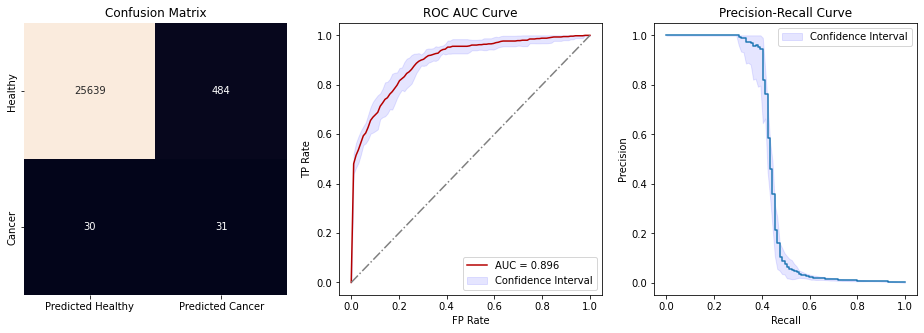

experiment_participants_screened_single_label_XGBClassifier_for_cancer_in_next_1_years_10_trials: 


Cross-Validation measures:
+--------------------+------------+-------------+------------+------------+
|                    |       mean |         std |        min |        max |
|--------------------+------------+-------------+------------+------------|
| precision__class_0 | 0.999138   | 4.96459e-05 | 0.999047   | 0.999206   |
| recall__class_0    | 0.963301   | 0.00146637  | 0.961528   | 0.966084   |
| f1-score__class_0  | 0.980892   | 0.00076025  | 0.979966   | 0.982328   |
| precision__class_1 | 0.00756515 | 0.00130774  | 0.00520833 | 0.00927835 |
| recall__class_1    | 0.251724   | 0.0431609   | 0.172414   | 0.310345   |
| f1-score__class_1  | 0.0146882  | 0.00253643  | 0.0101112  | 0.018018   |
| accuracy           | 0.962511   | 0.0014642   | 0.96073    | 0.96528    |
| auc                | 0.832423   | 0.00540657  | 0.822206   | 0.839701   |
+--------------------+------------+-

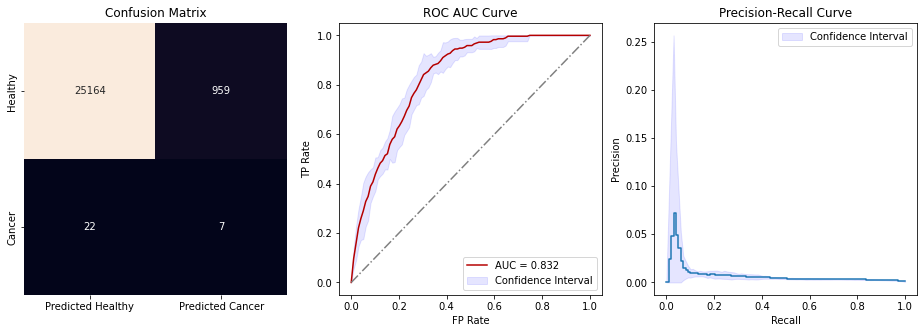

experiment_not_screened_cols_single_label_XGBClassifier_for_cancer_in_next_1_years_10_trials: 


Cross-Validation measures:
+--------------------+------------+-------------+-----------+------------+
|                    |       mean |         std |       min |        max |
|--------------------+------------+-------------+-----------+------------|
| precision__class_0 | 0.999308   | 5.91491e-05 | 0.99924   | 0.999429   |
| recall__class_0    | 0.883465   | 0.00589959  | 0.873295  | 0.891521   |
| f1-score__class_0  | 0.937814   | 0.00332632  | 0.932059  | 0.942367   |
| precision__class_1 | 0.00573164 | 0.000501177 | 0.0052622 | 0.00660714 |
| recall__class_1    | 0.522951   | 0.0412197   | 0.47541   | 0.606557   |
| f1-score__class_1  | 0.0113387  | 0.0009888   | 0.0104092 | 0.0130719  |
| accuracy           | 0.883004   | 0.00588477  | 0.872848  | 0.891093   |
| auc                | 0.832546   | 0.0092195   | 0.818673  | 0.846709   |
+--------------------+------------+-------------+--

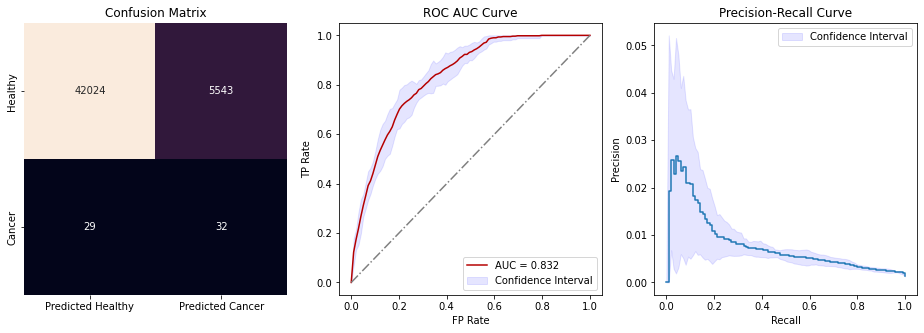

experiment_screened_cols_single_label_XGBClassifier_for_cancer_in_next_1_years_10_trials: 


Cross-Validation measures:
+--------------------+------------+-------------+------------+------------+
|                    |       mean |         std |        min |        max |
|--------------------+------------+-------------+------------+------------|
| precision__class_0 | 0.99897    | 3.14709e-05 | 0.998932   | 0.999037   |
| recall__class_0    | 0.942886   | 0.0177128   | 0.895226   | 0.957892   |
| f1-score__class_0  | 0.970039   | 0.00956278  | 0.94424    | 0.977996   |
| precision__class_1 | 0.0025339  | 0.000714041 | 0.00145932 | 0.00403877 |
| recall__class_1    | 0.124138   | 0.0241105   | 0.103448   | 0.172414   |
| f1-score__class_1  | 0.00496247 | 0.0013872   | 0.00288809 | 0.00789266 |
| accuracy           | 0.941978   | 0.0176886   | 0.894387   | 0.956944   |
| auc                | 0.579996   | 0.0142977   | 0.562837   | 0.605726   |
+--------------------+------------+---------

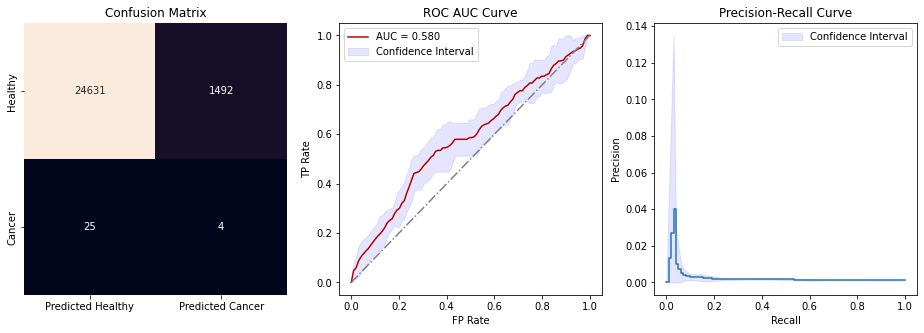

experiment_participants_all_single_label_XGBClassifier_for_cancer_in_next_1_years_10_trials: 


Cross-Validation measures:
+--------------------+-----------+-------------+------------+------------+
|                    |      mean |         std |        min |        max |
|--------------------+-----------+-------------+------------+------------|
| precision__class_0 | 0.999322  | 6.72091e-05 | 0.999196   | 0.999427   |
| recall__class_0    | 0.88281   | 0.00603584  | 0.868459   | 0.889419   |
| f1-score__class_0  | 0.937449  | 0.00341106  | 0.929296   | 0.941149   |
| precision__class_1 | 0.0058029 | 0.000517447 | 0.00506187 | 0.00668896 |
| recall__class_1    | 0.532787  | 0.0471658   | 0.442623   | 0.606557   |
| f1-score__class_1  | 0.0114805 | 0.00102232  | 0.0100093  | 0.013228   |
| accuracy           | 0.882361  | 0.00601308  | 0.868019   | 0.88891    |
| auc                | 0.833989  | 0.00939833  | 0.814954   | 0.843825   |
+--------------------+-----------+-------------+----

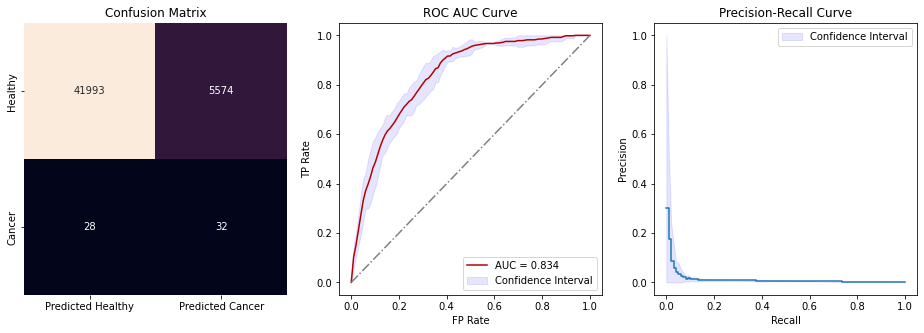

experiment_participants_screened_or_cancer_XGBClassifier_for_cancer_in_next_5_years_10_trials: 


Cross-Validation measures:
+--------------------+-----------+-------------+-----------+-----------+
|                    |      mean |         std |       min |       max |
|--------------------+-----------+-------------+-----------+-----------|
| precision__class_0 | 0.996418  | 9.0396e-05  | 0.996264  | 0.9966    |
| recall__class_0    | 0.971761  | 0.00175308  | 0.968376  | 0.973787  |
| f1-score__class_0  | 0.983934  | 0.000901533 | 0.982155  | 0.984982  |
| precision__class_1 | 0.0791411 | 0.0048942   | 0.0691358 | 0.0849195 |
| recall__class_1    | 0.40922   | 0.0149703   | 0.382979  | 0.439716  |
| f1-score__class_1  | 0.132583  | 0.0073265   | 0.117771  | 0.140777  |
| accuracy           | 0.968454  | 0.00174101  | 0.965018  | 0.97048   |
| auc                | 0.858744  | 0.00838073  | 0.846442  | 0.869994  |
+--------------------+-----------+-------------+-----------+-----------+

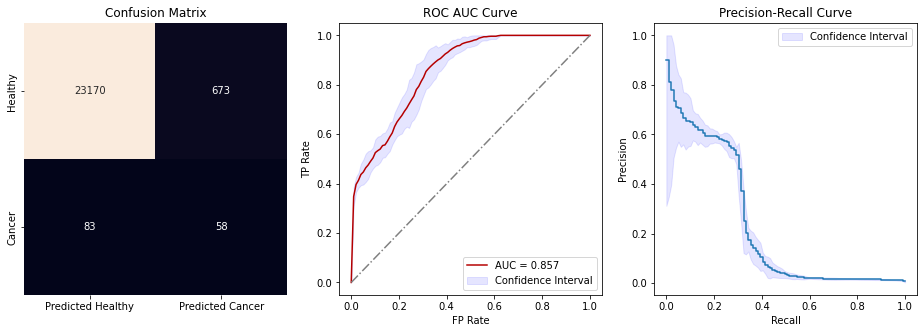

experiment_participants_screened_XGBClassifier_for_cancer_in_next_5_years_10_trials: 


Cross-Validation measures:
+--------------------+-----------+-------------+------------+-----------+
|                    |      mean |         std |        min |       max |
|--------------------+-----------+-------------+------------+-----------|
| precision__class_0 | 0.99696   | 0.000158451 | 0.996753   | 0.997229  |
| recall__class_0    | 0.955754  | 0.0031085   | 0.950072   | 0.960671  |
| f1-score__class_0  | 0.97592   | 0.00160238  | 0.973032   | 0.978535  |
| precision__class_1 | 0.0109792 | 0.00325472  | 0.00657277 | 0.016129  |
| recall__class_1    | 0.144444  | 0.0454728   | 0.0864198  | 0.222222  |
| f1-score__class_1  | 0.0204001 | 0.00605595  | 0.0122164  | 0.0300752 |
| accuracy           | 0.952999  | 0.00305289  | 0.947516   | 0.957996  |
| auc                | 0.794897  | 0.011133    | 0.778355   | 0.814263  |
+--------------------+-----------+-------------+------------+----------

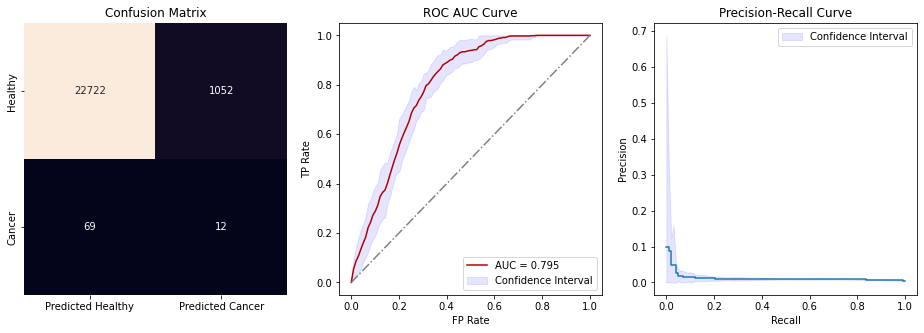

experiment_not_screened_cols_XGBClassifier_for_cancer_in_next_5_years_10_trials: 


Cross-Validation measures:
+--------------------+-----------+-------------+------------+-----------+
|                    |      mean |         std |        min |       max |
|--------------------+-----------+-------------+------------+-----------|
| precision__class_0 | 0.997653  | 0.000156228 | 0.997406   | 0.997958  |
| recall__class_0    | 0.886904  | 0.00622772  | 0.874359   | 0.89631   |
| f1-score__class_0  | 0.939014  | 0.00348577  | 0.931987   | 0.944337  |
| precision__class_1 | 0.0114386 | 0.00123602  | 0.00962979 | 0.0135104 |
| recall__class_1    | 0.385106  | 0.041898    | 0.319149   | 0.468085  |
| f1-score__class_1  | 0.0222156 | 0.00239083  | 0.0186955  | 0.0261757 |
| accuracy           | 0.885207  | 0.00617038  | 0.872817   | 0.894694  |
| auc                | 0.785218  | 0.00517563  | 0.777285   | 0.792138  |
+--------------------+-----------+-------------+------------+-----------+


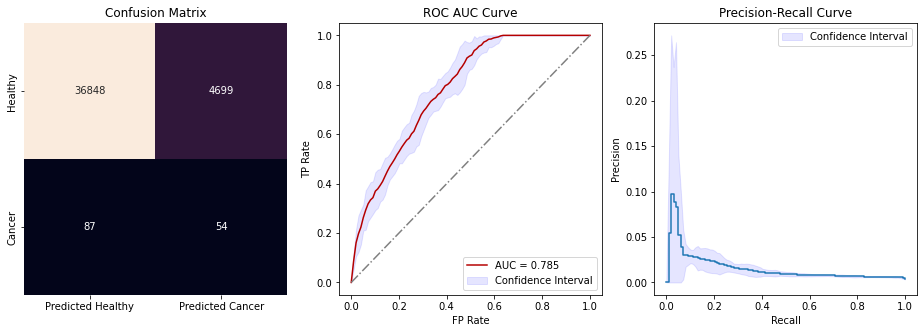

experiment_screened_cols_XGBClassifier_for_cancer_in_next_5_years_10_trials: 


Cross-Validation measures:
+--------------------+------------+-------------+------------+------------+
|                    |       mean |         std |        min |        max |
|--------------------+------------+-------------+------------+------------|
| precision__class_0 | 0.996808   | 8.48216e-05 | 0.996683   | 0.996967   |
| recall__class_0    | 0.936557   | 0.00421226  | 0.929671   | 0.94372    |
| f1-score__class_0  | 0.965739   | 0.00225865  | 0.962044   | 0.969535   |
| precision__class_1 | 0.00643718 | 0.00137105  | 0.00452196 | 0.00905923 |
| recall__class_1    | 0.119753   | 0.0218146   | 0.0864198  | 0.160494   |
| f1-score__class_1  | 0.0122153  | 0.00257844  | 0.00859423 | 0.0171504  |
| accuracy           | 0.933783   | 0.00422407  | 0.926892   | 0.940893   |
| auc                | 0.524572   | 0.0152095   | 0.500228   | 0.544383   |
+--------------------+------------+-------------+--------

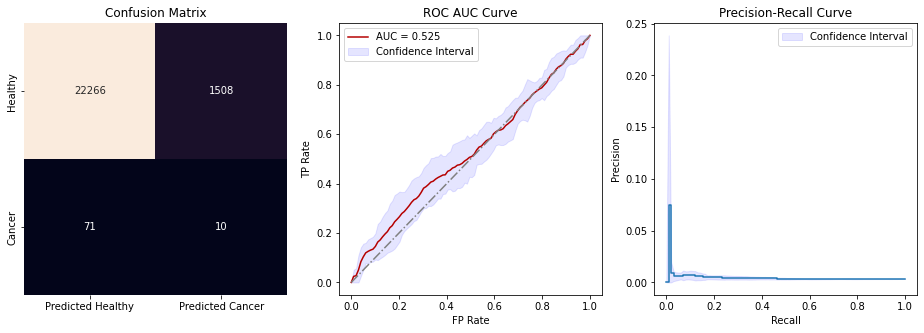

experiment_participants_all_XGBClassifier_for_cancer_in_next_5_years_10_trials: 


Cross-Validation measures:
+--------------------+-----------+-------------+-----------+-----------+
|                    |      mean |         std |       min |       max |
|--------------------+-----------+-------------+-----------+-----------|
| precision__class_0 | 0.997729  | 9.21477e-05 | 0.997589  | 0.997904  |
| recall__class_0    | 0.886317  | 0.00670574  | 0.876983  | 0.893951  |
| f1-score__class_0  | 0.938717  | 0.00377223  | 0.933443  | 0.942965  |
| precision__class_1 | 0.0120037 | 0.0010248   | 0.010838  | 0.0140719 |
| recall__class_1    | 0.405674  | 0.0235933   | 0.368794  | 0.446809  |
| f1-score__class_1  | 0.0233155 | 0.00196222  | 0.0211002 | 0.0272845 |
| accuracy           | 0.884691  | 0.00668812  | 0.87536   | 0.892247  |
| auc                | 0.792478  | 0.00591315  | 0.784858  | 0.804553  |
+--------------------+-----------+-------------+-----------+-----------+


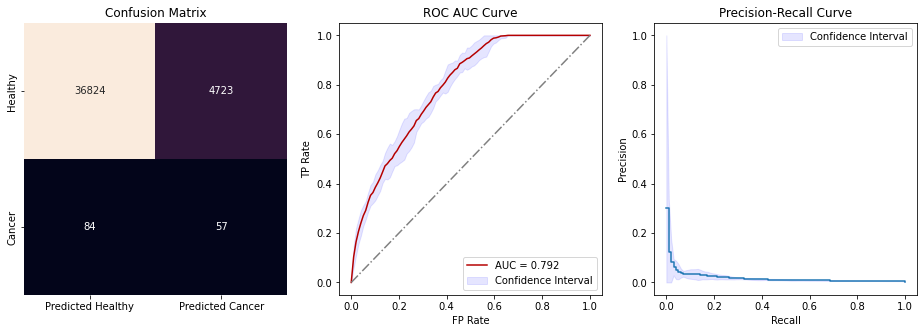

experiment_participants_screened_or_cancer_single_label_XGBClassifier_for_cancer_in_next_5_years_10_trials: 


Cross-Validation measures:
+--------------------+-----------+-------------+-----------+-----------+
|                    |      mean |         std |       min |       max |
|--------------------+-----------+-------------+-----------+-----------|
| precision__class_0 | 0.996289  | 9.12027e-05 | 0.996124  | 0.996418  |
| recall__class_0    | 0.972915  | 0.00217489  | 0.968949  | 0.97591   |
| f1-score__class_0  | 0.984462  | 0.00110243  | 0.98244   | 0.985914  |
| precision__class_1 | 0.0819916 | 0.00548093  | 0.0730479 | 0.0888889 |
| recall__class_1    | 0.399301  | 0.0152676   | 0.370629  | 0.41958   |
| f1-score__class_1  | 0.135956  | 0.00777121  | 0.123799  | 0.146699  |
| accuracy           | 0.969475  | 0.00213057  | 0.965571  | 0.97228   |
| auc                | 0.864824  | 0.0109025   | 0.845075  | 0.877665  |
+--------------------+-----------+-------------+-----------

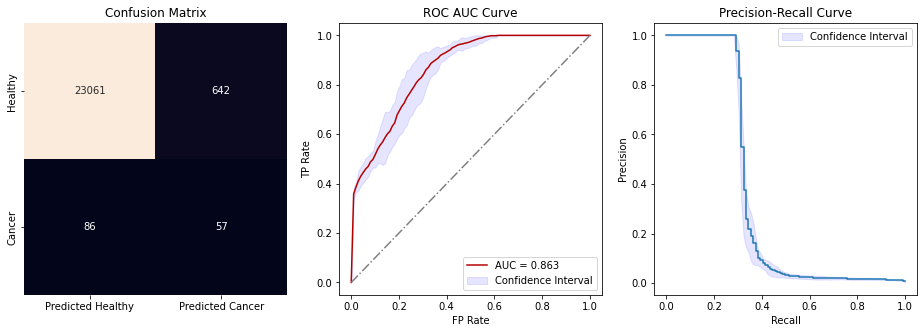

experiment_participants_screened_single_label_XGBClassifier_for_cancer_in_next_5_years_10_trials: 


Cross-Validation measures:
+--------------------+-----------+------------+------------+-----------+
|                    |      mean |        std |        min |       max |
|--------------------+-----------+------------+------------+-----------|
| precision__class_0 | 0.997074  | 0.00013032 | 0.99683    | 0.997238  |
| recall__class_0    | 0.956128  | 0.00477268 | 0.948994   | 0.964477  |
| f1-score__class_0  | 0.976166  | 0.00250788 | 0.97244    | 0.98057   |
| precision__class_1 | 0.0111201 | 0.00334267 | 0.00561798 | 0.0163551 |
| recall__class_1    | 0.147436  | 0.0368861  | 0.0769231  | 0.192308  |
| f1-score__class_1  | 0.0206646 | 0.00610675 | 0.0104712  | 0.0299786 |
| accuracy           | 0.953475  | 0.00478715 | 0.946386   | 0.961902  |
| auc                | 0.793775  | 0.0135265  | 0.775428   | 0.822822  |
+--------------------+-----------+------------+------------+---------

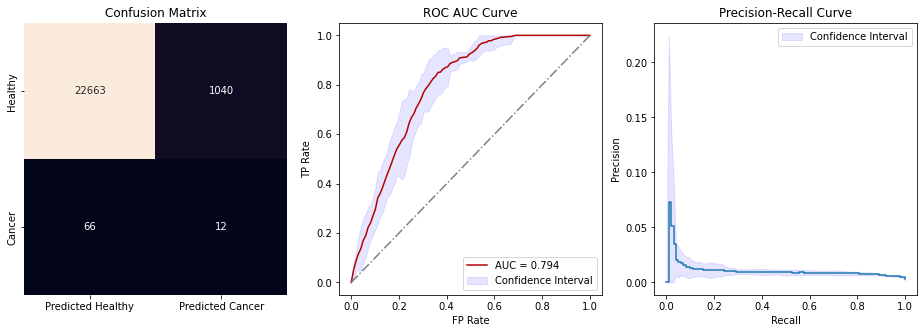

experiment_not_screened_cols_single_label_XGBClassifier_for_cancer_in_next_5_years_10_trials: 


Cross-Validation measures:
+--------------------+-----------+-------------+-----------+-----------+
|                    |      mean |         std |       min |       max |
|--------------------+-----------+-------------+-----------+-----------|
| precision__class_0 | 0.99766   | 0.000106905 | 0.99744   | 0.997792  |
| recall__class_0    | 0.892544  | 0.00635146  | 0.881543  | 0.902188  |
| f1-score__class_0  | 0.942168  | 0.00354914  | 0.936046  | 0.947485  |
| precision__class_1 | 0.0125287 | 0.00109086  | 0.0101302 | 0.0139943 |
| recall__class_1    | 0.393706  | 0.027393    | 0.342657  | 0.426573  |
| f1-score__class_1  | 0.0242825 | 0.00208953  | 0.0196787 | 0.0270704 |
| accuracy           | 0.890827  | 0.00632926  | 0.879954  | 0.900334  |
| auc                | 0.789523  | 0.0107442   | 0.766525  | 0.803375  |
+--------------------+-----------+-------------+-----------+-----------+


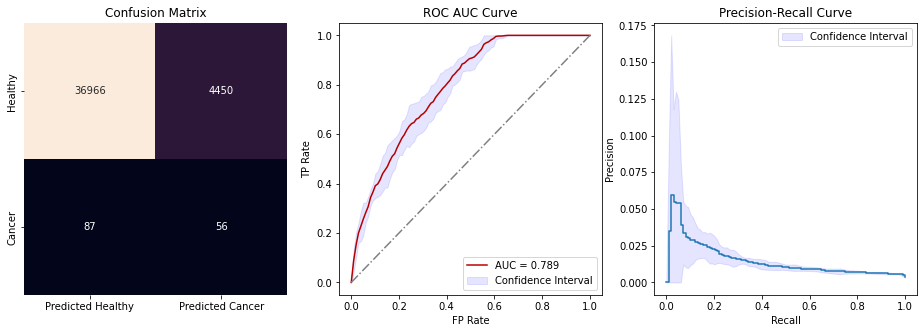

experiment_screened_cols_single_label_XGBClassifier_for_cancer_in_next_5_years_10_trials: 


Cross-Validation measures:
+--------------------+------------+-------------+------------+-----------+
|                    |       mean |         std |        min |       max |
|--------------------+------------+-------------+------------+-----------|
| precision__class_0 | 0.997045   | 0.000121756 | 0.996877   | 0.997232  |
| recall__class_0    | 0.933721   | 0.00577029  | 0.926549   | 0.942708  |
| f1-score__class_0  | 0.964336   | 0.00306827  | 0.960486   | 0.969036  |
| precision__class_1 | 0.00784401 | 0.00173657  | 0.00585652 | 0.0105634 |
| recall__class_1    | 0.158974   | 0.0358567   | 0.102564   | 0.217949  |
| f1-score__class_1  | 0.0149457  | 0.00329919  | 0.0110803  | 0.0200267 |
| accuracy           | 0.93118    | 0.00571989  | 0.924015   | 0.939952  |
| auc                | 0.528108   | 0.0177659   | 0.497518   | 0.552036  |
+--------------------+------------+-------------+------

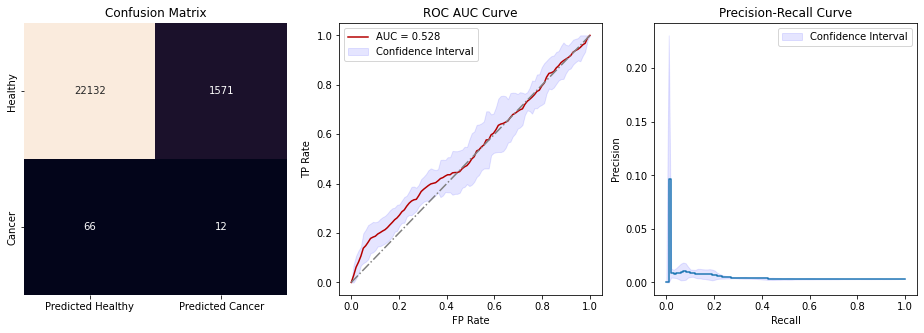

experiment_participants_all_single_label_XGBClassifier_for_cancer_in_next_5_years_10_trials: 


Cross-Validation measures:
+--------------------+-----------+-------------+-----------+-----------+
|                    |      mean |         std |       min |       max |
|--------------------+-----------+-------------+-----------+-----------|
| precision__class_0 | 0.997646  | 0.000106879 | 0.997502  | 0.997816  |
| recall__class_0    | 0.886116  | 0.00720606  | 0.878066  | 0.899507  |
| f1-score__class_0  | 0.938566  | 0.00399768  | 0.934102  | 0.945989  |
| precision__class_1 | 0.0118186 | 0.00058993  | 0.0110929 | 0.0127815 |
| recall__class_1    | 0.394406  | 0.0311344   | 0.34965   | 0.440559  |
| f1-score__class_1  | 0.0229471 | 0.0011442   | 0.0215526 | 0.0248423 |
| accuracy           | 0.884425  | 0.00710049  | 0.876537  | 0.89764   |
| auc                | 0.785434  | 0.00914947  | 0.766482  | 0.797393  |
+--------------------+-----------+-------------+-----------+-----------+


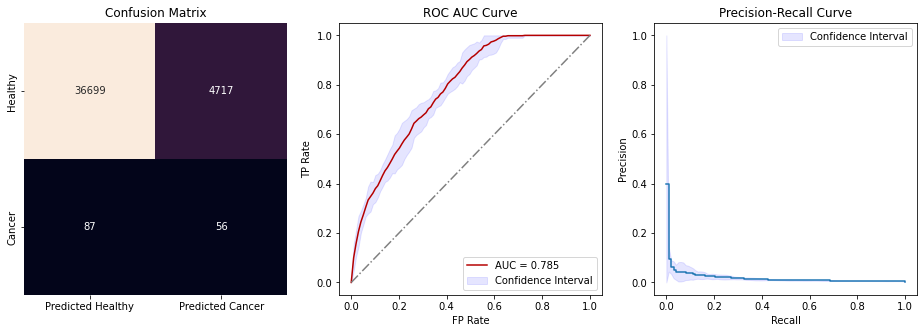

In [25]:
for key, cv_analytics_util in cv_analytics_utils.items():
    print(f"{key}: ")
    cv_analytics_util.get_cv_report();
    cv_analytics_util.display_graph()

In [26]:
cv_analytics_util.analytics_utils[0].data_util.train_df['ovar_histtype']

152137     2.00000
486606     2.00000
446584    10.09375
96060      2.00000
540065     2.00000
            ...   
10838      2.00000
59478     10.09375
69735      4.00000
86735      2.00000
239519     8.00000
Name: ovar_histtype, Length: 30000, dtype: float16

In [27]:
X_test_mismatch = cv_analytics_util.analytics_utils[0].get_high_confidence_errors()

In [28]:
false_negatives = pd.concat(np.array(X_test_mismatch)[:, 0])
false_negatives = false_negatives[false_negatives['cancer_in_next_1_years_prob'] < 0.14151879]
print_df(false_negatives)

KeyError: 'cancer_in_next_1_years_prob'

In [ ]:
len(false_negatives)

13

In [ ]:
print_df(pd.concat(X_test_mismatch[1][:2]))

+--------+-------+------------+-------------+-------+---------+-------+------------+-----------+-----------+-----------------+----------+-----------+----------+-----------+------------+------------+----------+-------------+-----------------+-----------------+--------------+------------+----------------+-----------------+----------+------------+------------+-------------+---------+-----------+---------------------+-----------+---------+---------+----------+----------+--------------+--------------+--------+--------+----------+------------+-----------------+-----------+-------------+--------------+-----------+--------------+------------+------------+--------------+----------+-------------+--------------+------------+-----------+--------+----------+-----------------------+-------------+-------------+---------+---------------------+-----------+-----------+-----------+-----------+-----------+----------+----------+-----------------+-----------+---------+-----------+---------------------+-----

In [ ]:
# drop col if the feature value of patient that was misclassified does not appear in the list of feature values of patients that were classified
df = pd.concat(X_test_mismatch[1][:2])
for col in df.columns:
    if df[col].iloc[0] in df[col].iloc[list(range(1, 6))].to_list():
        df.drop(col,inplace=True,axis=1)
print_df(df)
summary = summarize_features(df)

+--------+-------+-----------+----------+------------+------------+-------------+-----------+--------------+-----------+---------+-----------+--------------+---------------+-------------+--------------+---------------+--------------+---------+-------------+-----------+----------+------------+---------+--------------+--------------------------+-------------------------------+-------------------------------+------------+
|        |   age |   bcontrt |   bmi_20 |   bmi_curr |   cig_stop |   cig_years |   cigpd_f |   diabetes_f |   fchilda |   livec |   lmenstr |   ovary_diam |   ovary_diamr |   ovary_vol |   ovary_volr |   ovcyst_diam |   pack_years |   pregc |   rantero_p |   rtran_p |   rvol_p |   smokea_f |   thorm |   weight20_f |   cancer_in_next_1_years |   cancer_in_next_1_years_pred |   cancer_in_next_1_years_prob |   distance |
|--------+-------+-----------+----------+------------+------------+-------------+-----------+--------------+-----------+---------+-----------+------------

In [ ]:

df = pd.concat(X_test_mismatch[4][:2])
for col in df.columns:
    if len(df[col].unique()) <= 2:
        df.drop(col,inplace=True,axis=1)
print_df(df)
summary = summarize_features(df)
print_df(summary)

+--------+---------+-----------+-----------+----------+----------+------------+----------+------------+-----------------+----------+------------+------------+-------------+-----------+----------+------------+----------+-------------+---------+-----------+-----------+-----------+----------+-----------------+-----------+--------------+---------------+---------------+-------------+--------------+--------------+---------------+--------------+---------------+--------------+---------+-------------+-----------+-------------+-----------+----------+-----------+------------+-----------+--------------+--------------+------------+------------+
|        |   asppd |   bcontra |   bcontrt |   bmi_20 |   bmi_50 |   bmi_curr |   bq_age |   brothers |   ca125ii_level |   center |   cig_stat |   cig_stop |   cig_years |   cigpd_f |   educat |   height_f |   ibuppd |   lantero_p |   livec |   llong_p |   lmenstr |   ltran_p |   lvol_p |   mammo_history |   marital |   ovary_diam |   ovary_diaml |   ovary_